# Running attribute inference attacks on the Hospital data

In [1]:
from __future__ import annotations

import os
import sys
import logging
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import multiprocess as mp
import seaborn as sns
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor

np.set_printoptions(suppress=True)

ROOT_DIR = os.path.dirname(os.path.dirname(os.path.abspath("")))
sys.path.append(ROOT_DIR)
from data_preprocessing.data_interface import get_data_sklearn

logging.basicConfig()
logger = logging.getLogger("aia_hospital")
logger.setLevel(logging.INFO)

r_state = 1  # random seed
attack_threshold = 0  # infer atttributes only if unique highest confidence exceeds this

n_cpu = mp.cpu_count()  # number of CPU cores to use

INFO:/home/unknown/GRAIMatter/data_preprocessing/data_interface.py:ROOT PROJECT FOLDER = /home/unknown/GRAIMatter


## Utility class for storing dataset details

In [2]:
class Data:
    """Hospital dataset."""

    def __init__(self, seed: int) -> None:
        """Fetches the dataset and preprocesses."""

        self.data, self.target = get_data_sklearn("in-hospital-mortality")
        self.names: list[str] = self.data.columns

        self.data = self.data.round(3)

        self.X = np.asarray(self.data.values, dtype=np.float64)
        self.y = np.asarray(self.target.values, dtype=np.float64).ravel()

        # target model train / test split
        (
            self.Xt_member,
            self.Xt_nonmember,
            self.yt_member,
            self.yt_nonmember,
        ) = train_test_split(
            self.X,
            self.y,
            test_size=0.5,
            stratify=self.y,
            shuffle=True,
            random_state=seed,
        )

        self.X_train = self.Xt_member
        self.y_train = self.yt_member
        self.X_test = self.Xt_nonmember
        self.y_test = self.yt_nonmember

        self.n_samples: int = np.shape(self.X_train)[0]
        self.n_features: int = np.shape(self.X_train)[1]

        self.X_all = np.vstack((self.X_train, self.X_test))
        self.y_all = np.vstack((self.y_train, self.y_test))

        logger.info(f"X_train shape = {np.shape(self.X_train)}")
        logger.info(f"y_train shape = {np.shape(self.y_train)}")
        logger.info(f"X_test shape = {np.shape(self.X_test)}")
        logger.info(f"y_test shape = {np.shape(self.y_test)}")

## Utility class for storing attacked feature details

In [3]:
class AttackFeature:
    """Stores details of the attacked feature."""

    def __init__(self, ds: Data, index: int, indices: list[int]) -> None:
        """Initialises the definition of an attack feature."""
        self.index: int = index  # index of attacked feature
        self.name: str = ds.names[index]  # feature name
        self.indices: list[int] = indices  # encoded indices of attacked feature
        self.unique = np.unique(ds.X[:, self.index])  # unique attribute values
        self.n_unique: int = len(self.unique)  # number of unique attribute values
        # self.onehot_enc = OneHotEncoder()
        # self.values = self.onehot_enc.fit_transform(
        #    self.unique.reshape(-1, 1)
        # ).toarray()  # one-hot encoded unique attribute values
        self.values = self.unique
        self.X_values = None
        self.y_values = None
        self.naive: float = 0
        logger.debug(f"Attacked feature unique values: {self.unique}")

    def set_inference_data(self, model, ds: Data) -> None:
        """Returns a dataset of each sample with the attributes to test."""
        self.X_values = np.zeros(
            (ds.n_samples, self.n_unique, ds.n_features), dtype=np.float64
        )  # target model training set only
        self.y_values = model.predict(ds.X_train)
        # for each sample to perform inference on
        # add each possible missing feature value
        for i, x in enumerate(ds.X_train):
            for j, value in enumerate(self.values):
                self.X_values[i][j] = np.copy(x)
                self.X_values[i][j][self.indices] = value
        _, counts = np.unique(ds.Xt_member[:, self.index], return_counts=True)
        self.naive = (np.max(counts) / ds.n_samples) * 100
        logger.debug(f"X_values shape = {np.shape(self.X_values)}")
        logger.debug(f"y_values shape = {np.shape(self.y_values)}")

    def set_inference_data_all(self, model, ds: Data) -> None:
        """Returns a dataset of each sample with the attributes to test.
        Uses all train and test samples."""
        n_samples = len(ds.X_all)
        self.X_values = np.zeros(
            (n_samples, self.n_unique, ds.n_features), dtype=np.float64
        )  # target model training and test set
        self.y_values = model.predict(ds.X_all)
        # for each sample to perform inference on
        # add each possible missing feature value
        for i, x in enumerate(ds.X_all):
            for j, value in enumerate(self.values):
                self.X_values[i][j] = np.copy(x)
                self.X_values[i][j][self.indices] = value
        _, counts = np.unique(ds.X[:, self.index], return_counts=True)
        self.naive = (np.max(counts) / n_samples) * 100
        logger.debug(f"X_values shape = {np.shape(self.X_values)}")
        logger.debug(f"y_values shape = {np.shape(self.y_values)}")

    def set_inference_data_linspace(self, model, ds: Data, feat_n: int) -> None:
        """Returns a dataset of each sample with the attributes to test.
        Uses training set and feat_n linearly sampled values for missing attributes."""
        feat_min = np.min(ds.X_train[:, self.index])
        feat_max = np.max(ds.X_train[:, self.index])
        x_feat = np.linspace(feat_min, feat_max, feat_n, endpoint=True)
        self.X_values = np.zeros(
            (ds.n_samples, feat_n, ds.n_features), dtype=np.float64
        )
        for i, x in enumerate(ds.X_train):
            x1 = np.repeat(x.reshape(1, -1), feat_n, axis=0)
            x1[:, self.index] = x_feat
            self.X_values[i] = x1
        self.y_values = model.predict(ds.X_train)
        self.n_unique = feat_n
        logger.debug(f"{self.name}: [{feat_min}, {feat_max}]")

## Utility functions

In [4]:
def unique_max(confidences: list[float], threshold: float) -> bool:
    """Returns whether there is a unique maximum confidence value above threshold."""
    if len(confidences) > 0:
        max_conf = np.max(confidences)
        if max_conf < threshold:
            return False
        u, c = np.unique(confidences, return_counts=True)
        for i in range(len(c)):
            if c[i] == 1 and u[i] == max_conf:
                return True
    return False

## Load data

In [5]:
dataset = Data(r_state)

INFO:/home/unknown/GRAIMatter/data_preprocessing/data_interface.py:DATASET FOLDER = /home/unknown/GRAIMatter/data
INFO:aia_hospital:X_train shape = (214, 48)
INFO:aia_hospital:y_train shape = (214,)
INFO:aia_hospital:X_test shape = (214, 48)
INFO:aia_hospital:y_test shape = (214,)


In [6]:
dataset.data.head()

,age,gendera,BMI,hypertensive,atrialfibrillation,CHD with no MI,diabetes,deficiencyanemias,depression,Hyperlipemia,...,Blood sodium,Blood calcium,Chloride,Anion gap,Magnesium ion,PH,Bicarbonate,Lactic acid,PCO2,EF
0,72,1,37.588,0,0,0,1,1,0,1,...,138.750,7.464,109.167,13.167,2.618,7.230,21.167,0.500,40.000,55
2,83,2,26.573,0,0,0,0,1,0,0,...,140.714,8.267,105.857,10.000,2.157,7.268,30.571,0.500,71.500,35
3,43,2,83.265,0,0,0,0,0,0,0,...,138.500,9.477,92.071,12.357,1.943,7.370,38.571,0.600,75.000,55
5,76,1,24.262,1,1,0,0,1,0,1,...,136.250,8.467,96.750,13.125,1.771,7.310,30.500,0.600,65.500,35
6,72,1,39.667,1,0,0,0,0,0,1,...,144.133,8.775,106.667,15.200,1.875,7.169,26.800,0.625,69.769,55


In [7]:
dataset.data.describe()

,age,gendera,BMI,hypertensive,atrialfibrillation,CHD with no MI,diabetes,deficiencyanemias,depression,Hyperlipemia,...,Blood sodium,Blood calcium,Chloride,Anion gap,Magnesium ion,PH,Bicarbonate,Lactic acid,PCO2,EF
count,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,...,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000
mean,72.514019,1.516355,30.858407,0.703271,0.422897,0.067757,0.457944,0.336449,0.130841,0.343458,...,139.326963,8.448077,102.614110,14.116533,2.135196,7.374790,26.820921,1.900341,45.381161,48.154206
std,13.424689,0.500317,9.630070,0.457351,0.494598,0.251623,0.498811,0.473047,0.337621,0.475418,...,3.926646,0.563462,5.200161,2.644294,0.242169,0.065744,5.621579,0.997929,13.019610,13.043058
min,35.000000,1.000000,13.674000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,121.045000,6.700000,85.643000,7.778000,1.414000,7.158000,12.857000,0.500000,19.500000,15.000000
25%,63.000000,1.000000,24.431250,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,137.000000,8.089750,99.306000,12.250000,1.978750,7.330000,23.000000,1.200000,36.958250,40.000000
50%,74.000000,2.000000,28.430000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,139.727000,8.441000,102.636000,13.891000,2.100000,7.376000,26.187000,1.660000,42.450000,55.000000
75%,84.000000,2.000000,34.460250,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,...,142.000000,8.800000,105.865000,15.673250,2.243500,7.425000,29.750000,2.300000,50.520750,55.000000
max,99.000000,2.000000,83.265000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,149.133000,10.950000,117.316000,25.273000,4.073000,7.560000,47.667000,6.725000,98.600000,75.000000


## Train target model

In [8]:
model = RandomForestClassifier(bootstrap=False, random_state=r_state)
model.fit(dataset.X_train, dataset.y_train)

print(f"Base model train accuracy: {model.score(dataset.X_train, dataset.y_train)}")
print(f"Base model test accuracy: {model.score(dataset.X_test, dataset.y_test)}")

Base model train accuracy: 1.0
Base model test accuracy: 0.8644859813084113


## Attribute inference using target model confidence scores and predicted labels

In [9]:
def infer(model, ds: Data, af: AttackFeature, threshold: float) -> str:
    """
    For each possible missing value, compute the confidence scores and
    label with the target model; if the label matches the known target model
    label for the original sample, and the highest confidence score is unique,
    infer that attribute if the confidence score is greater than a threshold.
    """

    correct: int = 0  # number of correct inferences made
    total: int = 0  # total number of inferences made

    for i, x in enumerate(af.X_values):  # each sample to perform inference on
        # get target model confidence scores for all possible values for the sample
        confidence = model.predict_proba(x)
        # get known target model predicted label for the original sample
        label = af.y_values[i]
        conf = []  # confidences for each possible value with correct label
        attr = []  # features for each possible value with correct label
        # for each possible attribute value,
        # if the label matches the target model label
        # then store the confidence score and the tested feature vector
        for j in range(af.n_unique):
            this_label = np.argmax(confidence[j])
            scores = confidence[j][this_label]
            if this_label == label:
                conf.append(scores)
                attr.append(x[j])
        # get whether there is a unique maximum confidence score greater than threshold
        if unique_max(conf, threshold):
            total += 1
            # tested sample matches the original input feature
            inf = attr[np.argmax(conf)]  # infered feature vector
            inf_attr = inf[af.index]  # infered attribute
            if inf_attr == ds.X_train[i][af.index]:
                correct += 1

    if total > 0:
        msg = (
            f"Correctly inferred: {(correct / total) * 100:.2f}% "
            f"of {(total / len(ds.X_train)) * 100:.2f}% of the data set\n"
            f"Baseline: {af.naive:.2f}%"
        )
    else:
        msg = "unable to make any inferences"
    return f"Attacking feature {af.name} with {af.n_unique} unique values:\n{msg}"

In [10]:
# create a list of features to attack
attack_features: list[AttackFeature] = []

for i in range(dataset.n_features):
    attack_features.append(AttackFeature(dataset, i, [i]))

In [11]:
# for each attacked feature build a matrix of all possible values
# uses training set samples - i.e., assumes attacker knows sample is in dataset
for af in attack_features:
    af.set_inference_data(model, dataset)
    # af.set_inference_data_linspace(model, dataset, 100)

In [12]:
# utility function for collecting parallel processed inferences
results: list[str] = []


def collect_results(result: str) -> None:
    """Collects parallel processed inference results."""
    results.append(result)

In [13]:
# for each feature test each possible value and infer the attribute where possible

pool = mp.Pool(processes=n_cpu)
for af in attack_features:
    pool.apply_async(
        infer,
        args=(
            model,
            dataset,
            af,
            attack_threshold,
        ),
        callback=collect_results,
    )
pool.close()
pool.join()

for result in results:
    print(f"{result}\n")

Attacking feature gendera with 2 unique values:
Correctly inferred: 100.00% of 17.29% of the data set
Baseline: 50.00%

Attacking feature age with 60 unique values:
Correctly inferred: 100.00% of 0.47% of the data set
Baseline: 11.68%

Attacking feature hypertensive with 2 unique values:
Correctly inferred: 100.00% of 15.42% of the data set
Baseline: 71.50%

Attacking feature CHD with no MI with 2 unique values:
Correctly inferred: 100.00% of 32.71% of the data set
Baseline: 92.99%

Attacking feature atrialfibrillation with 2 unique values:
Correctly inferred: 100.00% of 9.81% of the data set
Baseline: 60.75%

Attacking feature diabetes with 2 unique values:
Correctly inferred: 100.00% of 20.56% of the data set
Baseline: 53.74%

Attacking feature deficiencyanemias with 2 unique values:
Correctly inferred: 100.00% of 25.23% of the data set
Baseline: 65.89%

Attacking feature BMI with 416 unique values:
unable to make any inferences

Attacking feature depression with 2 unique values:
Cor

## Membership inference attack
#### Construct a dataset with the label of whether or not in the training

In [14]:
miX = model.predict_proba(dataset.X_all)

miY = np.vstack(
    (np.ones((len(dataset.X_train), 1), int), np.zeros((len(dataset.X_test), 1), int))
).flatten()

mi_train_x, mi_test_x, mi_train_y, mi_test_y = train_test_split(
    miX, miY, test_size=0.2, stratify=miY
)

logger.info(f"mi_train_x shape = {np.shape(mi_train_x)}")
logger.info(f"mi_train_y shape = {np.shape(mi_train_y)}")
logger.info(f"mi_test_x shape = {np.shape(mi_test_x)}")
logger.info(f"mi_test_y shape = {np.shape(mi_test_y)}")

INFO:aia_hospital:mi_train_x shape = (342, 2)
INFO:aia_hospital:mi_train_y shape = (342,)
INFO:aia_hospital:mi_test_x shape = (86, 2)
INFO:aia_hospital:mi_test_y shape = (86,)


#### Train membership inference attack model

In [15]:
mi_attack_model = RandomForestClassifier()
mi_attack_model.fit(mi_train_x, mi_train_y)

pred_probs = mi_attack_model.predict_proba(mi_test_x)
mi_auc = roc_auc_score(mi_test_y, pred_probs[:, 1])
print(f"Membership AUC = {mi_auc}")

Membership AUC = 0.981611681990265


## Specificity of attribute inference using target model maximum confidence

Given a sample feature vector with a missing attribute and the target model predicted label, this computes the target model confidence scores for the sample with 100 linearly sampled values for the missing attribute. The number of maximum confidence score peaks is recorded, along with the cumulative width of all peaks. This process is repeated for all samples (here training set samples) and the widths are used to plot histograms (10 bins) that show the specificity of the maximum confidence prediction. The area under the curve (AUC) of the cumulative histogram thus provides a measure of the risk of attribute disclosure. The specificity is here reported as a unitless measure representing the number of linearly sampled values.

(Linearly sampled may not make sense for categorical data.)

In [16]:
logging.getLogger("matplotlib").setLevel(logging.WARNING)


def get_conf_stats(model, ds: Data, feat: int, sample_id: int) -> [float, int, float]:
    """Returns the maximum confidence score, number of peaks and its combined
    width from a target model for a given input vector where the missing
    attribute is linearly sampled."""
    name: str = ds.names[feat]
    feat_min: float = np.min(ds.X_train[:, feat])
    feat_max: float = np.max(ds.X_train[:, feat])
    feat_n: int = 100  # number of attribute values to test per sample
    # attribute values to test - linearly sampled
    x_feat = np.linspace(feat_min, feat_max, feat_n, endpoint=True)
    # get sample feature vector
    sample = ds.X_train[sample_id]
    # get known label
    label = int(model.predict(sample.reshape(1, -1))[0])
    # create a matrix containing feature vector with linearly spaced target attribute
    x1 = np.repeat(sample.reshape(1, -1), feat_n, axis=0)
    x1[:, feat] = x_feat
    # get the target model confidences across the attribute range
    confidences = model.predict_proba(x1)
    scores = confidences[:, label]  # conf scores just for the model predicted label
    # calculate the combined width of all peaks
    peak = np.max(scores)
    width = np.count_nonzero(scores == peak)  # unitless
    # width *= (feat_max - feat_min) / feat_n  # unit
    # calculate the number of peaks
    n_peaks = 0
    for i in range(len(scores)):
        if scores[i] == peak and (n_peaks == 0 or scores[i - 1] != peak):
            n_peaks += 1
    # print(f"feat {feat}: {n_peaks} peaks")
    # if n_peaks == 3:
    #    plt.figure(figsize=(6, 3))
    #    plt.plot(x_feat, scores)
    #    plt.grid(linestyle="dotted", linewidth=1)
    #    plt.title(f"Sample {sample_id} - Original Attr: {sample[feat]}", fontsize=14)
    #    plt.xlabel(f"{name}", fontsize=12)
    #    plt.ylabel("Confidence", fontsize=12)
    #    plt.axvline(x=sample[feat], color="black", ls="--", lw=2)
    return width, n_peaks, peak

In [17]:
def plot_specificity(w: np.ndarray, name: str) -> None:
    """Generates histograms given max confidence score widths."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 3))
    plt.subplots_adjust(wspace=0.5)
    fig.suptitle(f"{name}", fontsize=18)
    # cumulative histogram
    ax1.grid(linestyle="dotted", linewidth=1)
    ax1.set_xlabel("Specificity of Maximum Confidence Prediction", fontsize=12)
    ax1.set_ylabel("Proportion of Training Set", fontsize=12)
    values, bins, _ = ax1.hist(
        w, bins=10, cumulative=True, range=(0, 100), weights=np.ones(len(w)) / len(w)
    )
    auc = sum(np.diff(bins) * values)
    ax1.set_title(f"Cumulative (AUC: {auc:.2f})")
    # standard histogram
    ax2.grid(linestyle="dotted", linewidth=1)
    ax2.set_xlabel("Specificity of Maximum Confidence Prediction", fontsize=12)
    ax2.set_ylabel("Proportion of Training Set", fontsize=12)
    ax2.hist(
        w, bins=10, cumulative=False, range=(0, 100), weights=np.ones(len(w)) / len(w)
    )
    ax2.set_title("Standard")
    # sns.kdeplot(w)

## bounds risk
I've been thinking about conversations with Felix about what various national stats institutes do for continuous variables,
And their rules of thumb is “upper and lower bounds of estimate can’t be within 10% of actual value”

We will assume the TRE provides a threshold for confidence c_min below which it does not care
(So currently we set c_min= 0)

And a range k (e.g. 10%)

For lets say we have an attribute A,
A training set T with items x in 1…..n

A confidence threshold C

Then for attribute A and training item x we can predict the confidence of our attack model when x_A= j.  as Conf(A,x,j)

Let c*(Aux) = max_j Conf(A,x,j)
And j_min, j_max be the minimum and max values of j such that Conf(A,x,j)=c*(A,x)

Thern the ‘risk factor’ is proportion of T such that:
(I) c*(A,X) >= c_min

(ii) Conf(A,x,j_actual)) = c*(A,x).    Where j_actual is the true value of a for item x.  (System is never more confident than it is for actual lvalue)

(iii)  j_min >= (1-k) j_actual.  Lower bound with k%

(iv) j_max <= (1+k) j_actual.  User bound within k%


Note that this metric doesn’t care if there are multiple peaks, it just insists that the actual point has the jhighest c


In [ ]:
# defines the confidence threshold below which we say we don;t care.
c_min = 0

# lower [upper] bound on estimated value must not be above[below] lower[upper] boundfs e.g.  10% of value
protection_limit = 0.1

#number of different values tried for the attribute we are trying to infer 
num_samples = 100




def get_bounds_risk_for_sample(model, ds: Data, feat: int, sample_id: int, c_min:float,protection_limit:float) -> [float, float, float]:
    """Returns bool based on conditions surrounding
      upper and lower bounds of guesses 
    that would lead to the same model confidence."""
    name: str = ds.names[feat]
    feat_min: float = np.min(ds.X_train[:, feat])
    feat_max: float = np.max(ds.X_train[:, feat])
    feat_n: int = 100  # number of attribute values to test per sample
    # attribute values to test - linearly sampled
    x_feat = np.linspace(feat_min, feat_max, feat_n, endpoint=True)
    # get sample feature vector
    sample = ds.X_train[sample_id]
    # get known label
    label = int(model.predict(sample.reshape(1, -1))[0])
    # create a matrix containing feature vector with linearly spaced target attribute
    x1 = np.repeat(sample.reshape(1, -1), feat_n, axis=0)
    x1[:, feat] = x_feat
    # get the target model confidences across the attribute range
    confidences = model.predict_proba(x1)
    scores = confidences[:, label]  # conf scores just for the model predicted label
    # calculate the combined width of all peaks
    peak = np.max(scores)
    
    #find lowest and highest values with peak confidence
    lower_bound_index = 0 
    while confidences[lower_bound_index]< peak:
        lower_bound_index +=1
        
    upper_bound_index = feat_n -1
    while confidences[upper_bound_index]< peak:
        upper_bound_index -=1
        
        
    #RICHARD check next line
    actual_value = sample[feat]
    
    at_risk = False
    
    #condition1: confidence in prediction above some threshold
    if (peak > c_min):
        conf_above_threshold= True
    
        # condition 2: confidence for true value ==max_confidence
        actual_probs= model.predict_proba[sample]
        if actual_probs[label] ==peak:
            
            # condition 3 lower bound above lower protection limit
            lower_bound = x_feat[lower_bound_index] 
            if lower_bound >= protection_limit * actual_value :
                
                #condition 4: upper boiund of estiamte below upper protection limit
                upper_bound = x_feat[upper_bound_index]
                if upper_bound <= (1 + protection_limit) * actual_value:
                    at_risk = True
                
        
        
        
    return at_risk  
        
    
    

    

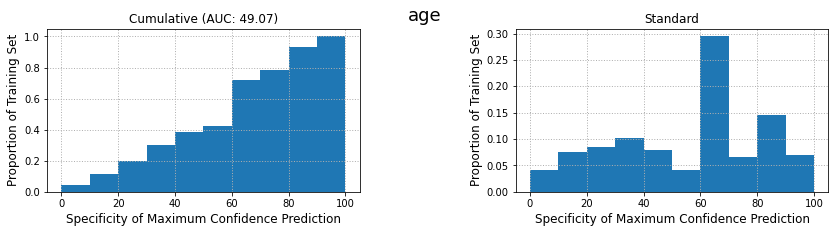

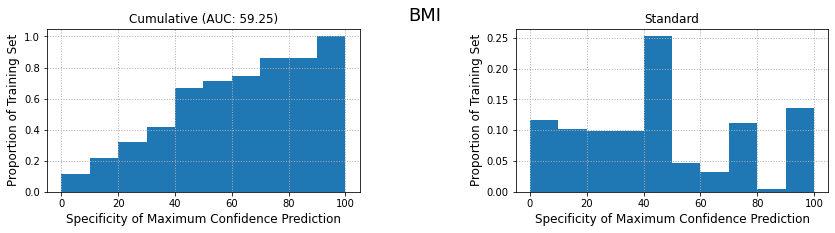

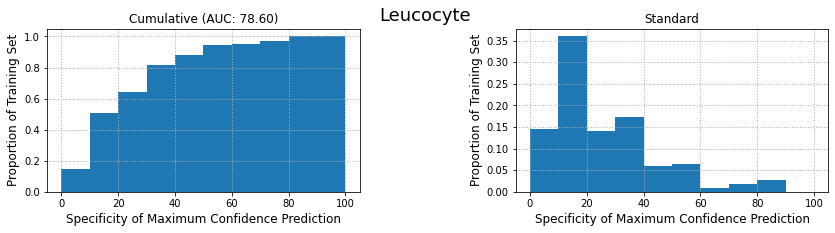

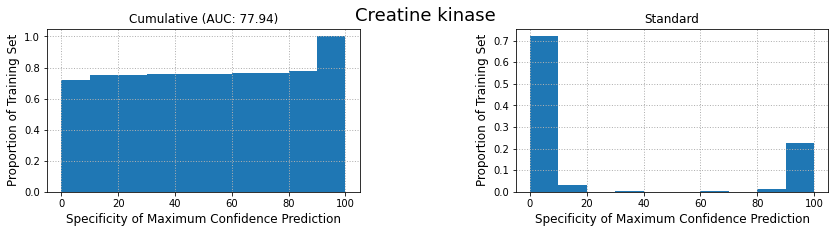

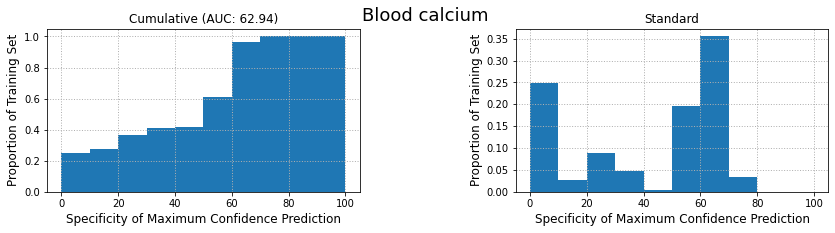

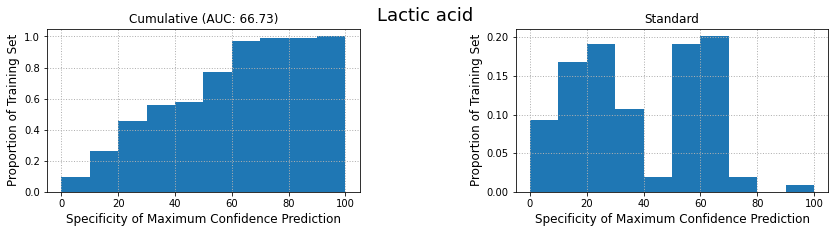

In [18]:
threshold: float = 0  # [disabled] zero the samples with small confidence peaks

feature_list = [0, 2, 25, 33, 39, 45]

# for feat_i in range(dataset.n_features):  # all features
for feat_i in feature_list:
    widths = np.zeros((dataset.n_samples,), dtype=np.float64)
    for sample_i in range(dataset.n_samples):  # all samples
        width, n_peaks, peak = get_conf_stats(model, dataset, feat_i, sample_i)
        if peak > threshold:
            widths[sample_i] = width
    plot_specificity(widths, dataset.names[feat_i])

## Attribute inference and membership inference
Same attack as above, however training set membership is not assumed, and a membership inference model is used first to classify member/non-member.

In [19]:
def infer(model, mia_model, ds: Data, af: AttackFeature, threshold: float) -> str:
    """Infers the missing feature values."""

    correct: int = 0  # number of correct inferences made
    total: int = 0  # total number of inferences made

    for i, x in enumerate(af.X_values):  # each sample to perform inference on
        # get target model confidence scores for all possible values for the sample
        confidence = model.predict_proba(x)
        # get membership inference model confidence scores for the tested sample
        mi_confidence = mia_model.predict_proba(confidence)
        # get known target model predicted label for the original sample
        label = af.y_values[i]
        conf = []  # confidences for each possible value with correct label
        attr = []  # features for each possible value with correct label
        # for each possible attribute value,
        # if mia predicts memberset and label matches target model
        # then store the confidence score and the tested feature vector
        for j in range(af.n_unique):
            mia_label = np.argmax(mi_confidence[j])
            this_label = np.argmax(confidence[j])
            if mia_label == 1 and this_label == label:
                scores = confidence[j][this_label]
                conf.append(scores)
                attr.append(x[j])
        # get whether there is a unique maximum confidence score greater than threshold
        if unique_max(conf, threshold):
            total += 1
            # tested sample matches the original input feature
            inf = attr[np.argmax(conf)]  # infered feature vector
            inf_attr = inf[af.index]  # infered attribute
            if inf_attr == ds.X_all[i][af.index]:
                correct += 1

    if total > 0:
        msg = (
            f"Correctly inferred: {(correct / total) * 100:.2f}% "
            f"of {(total / len(ds.X_all)) * 100:.2f}% of the data set\n"
            f"Baseline: {af.naive:.2f}%"
        )
    else:
        msg = "unable to make any inferences"
    return f"Attacking feature {af.name} with {af.n_unique} unique values:\n{msg}"

In [20]:
# uses training and testing set - i.e., does not assume dataset membership
for af in attack_features:
    af.set_inference_data_all(model, dataset)

In [21]:
# for each feature test each possible value and infer the attribute where possible

results = []

pool = mp.Pool(processes=n_cpu)
for af in attack_features:
    pool.apply_async(
        infer,
        args=(
            model,
            mi_attack_model,
            dataset,
            af,
            attack_threshold,
        ),
        callback=collect_results,
    )
pool.close()
pool.join()

for result in results:
    print(f"{result}\n")

Attacking feature gendera with 2 unique values:
Correctly inferred: 100.00% of 8.64% of the data set
Baseline: 51.64%

Attacking feature age with 60 unique values:
Correctly inferred: 100.00% of 0.23% of the data set
Baseline: 9.58%

Attacking feature atrialfibrillation with 2 unique values:
Correctly inferred: 100.00% of 4.91% of the data set
Baseline: 57.71%

Attacking feature deficiencyanemias with 2 unique values:
Correctly inferred: 98.18% of 12.85% of the data set
Baseline: 66.36%

Attacking feature hypertensive with 2 unique values:
Correctly inferred: 100.00% of 7.71% of the data set
Baseline: 70.33%

Attacking feature CHD with no MI with 2 unique values:
Correctly inferred: 100.00% of 16.36% of the data set
Baseline: 93.22%

Attacking feature diabetes with 2 unique values:
Correctly inferred: 100.00% of 10.51% of the data set
Baseline: 54.21%

Attacking feature BMI with 416 unique values:
unable to make any inferences

Attacking feature depression with 2 unique values:
Correct

## Attribute inference using a membership inference attack model
The idea is to find the target feature value that causes the membership inference attack to classify the sample as a member with the highest confidence. Here the attacker is not sure if the sample is in the training set.

In [22]:
def infer_mia(model, mia_model, ds: Data, af: AttackFeature, threshold: float) -> None:
    """Infers the missing feature values with a membership inference attack model."""

    correct: int = 0  # number of correct inferences made
    total: int = 0  # total number of inferences made

    for i, x in enumerate(af.X_values):  # each sample to perform inference on
        # get target model confidence scores for all possible values for the sample
        confidence = model.predict_proba(x)
        # get membership inference model confidence scores for the tested sample
        mi_confidence = mia_model.predict_proba(confidence)
        conf = []  # confidences for each possible value with member label
        attr = []  # features for each possible value with member label
        # for each possible attribute value,
        # if the membership inference model predicts training set membership
        # then store the confidence score and the tested feature vector
        for j in range(af.n_unique):
            this_label = np.argmax(mi_confidence[j])
            scores = mi_confidence[j][this_label]
            if this_label == 1:  # membership attack model predicts member
                conf.append(scores)
                attr.append(x[j])
        # get whether there is a unique maximum confidence score greater than threshold
        if unique_max(conf, threshold):
            total += 1
            # tested sample matches the original input feature
            inf = attr[np.argmax(conf)]  # infered feature vector
            inf_attr = inf[af.index]  # infered attribute
            if inf_attr == ds.X_all[i][af.index]:
                correct += 1

    if total > 0:
        msg = (
            f"Correctly inferred: {(correct / total) * 100:.2f}% "
            f"of {(total / len(ds.X_all)) * 100:.2f}% of the data set\n"
            f"Baseline: {af.naive:.2f}%"
        )
    else:
        msg = "unable to make any inferences"
    return f"Attacking feature {af.name} with {af.n_unique} unique values:\n{msg}"

In [23]:
# uses training and testing set - i.e., does not assume dataset membership

results = []

pool = mp.Pool(processes=n_cpu)
for af in attack_features:
    pool.apply_async(
        infer_mia,
        args=(
            model,
            mi_attack_model,
            dataset,
            af,
            attack_threshold,
        ),
        callback=collect_results,
    )
pool.close()
pool.join()

for result in results:
    print(f"{result}\n")

Attacking feature gendera with 2 unique values:
Correctly inferred: 100.00% of 4.21% of the data set
Baseline: 51.64%

Attacking feature age with 60 unique values:
unable to make any inferences

Attacking feature hypertensive with 2 unique values:
Correctly inferred: 100.00% of 5.14% of the data set
Baseline: 70.33%

Attacking feature atrialfibrillation with 2 unique values:
Correctly inferred: 100.00% of 3.97% of the data set
Baseline: 57.71%

Attacking feature diabetes with 2 unique values:
Correctly inferred: 100.00% of 6.31% of the data set
Baseline: 54.21%

Attacking feature CHD with no MI with 2 unique values:
Correctly inferred: 100.00% of 11.92% of the data set
Baseline: 93.22%

Attacking feature deficiencyanemias with 2 unique values:
Correctly inferred: 96.97% of 7.71% of the data set
Baseline: 66.36%

Attacking feature BMI with 416 unique values:
unable to make any inferences

Attacking feature Renal failure with 2 unique values:
Correctly inferred: 100.00% of 17.29% of the 

## Attribute inference mapping n-1 features and labels to the missing feature
This black-box attack trains an additional classifier (the attack model) to predict the attacked feature's value from the remaining n-1 features as well as the original (target) model's predictions.

In [24]:
def get_bb_data(ds: Data, af: AttackFeature):
    """Returns data for fitting a black-box model on n-1 features plus predictions."""
    # combine predictions with n-1 features for attack model input
    Xa = np.copy(ds.X_train)
    predictions = model.predict_proba(Xa)  # get target model's confidences
    Xa = np.delete(Xa, af.indices, axis=1)  # drop attacked feature
    Xa = np.concatenate((Xa, predictions), axis=1)  # combine label predictions
    # get target vector of attacked feature
    ya = ds.Xt_member[:, af.index]
    # encode target vector
    if ds.data.dtypes[af.index] == "float64":  # continuous
        attacked_feature_encoder = StandardScaler()
        Xa = attacked_feature_encoder.fit_transform(Xa)
        ya = attacked_feature_encoder.fit_transform(ya.reshape(-1, 1)).ravel()
    else:  # discrete
        attacked_feature_encoder = LabelEncoder()
        ya = attacked_feature_encoder.fit_transform(ya)
    # attack model train / test split
    Xa_train, Xa_test, ya_train, ya_test = train_test_split(
        Xa, ya, test_size=0.2, shuffle=False, random_state=r_state
    )
    return Xa_train, ya_train, Xa_test, ya_test, attacked_feature_encoder

In [25]:
attack_classifiers = []

attack_classifiers.append(
    [
        "MLPClassifier",
        MLPClassifier(
            hidden_layer_sizes=(100,),
            activation="relu",
            solver="adam",
            alpha=0.0001,
            batch_size="auto",
            learning_rate="constant",
            learning_rate_init=0.001,
            power_t=0.5,
            max_iter=2000,
            shuffle=True,
            random_state=r_state,
            tol=0.0001,
            verbose=False,
            warm_start=False,
            momentum=0.9,
            nesterovs_momentum=True,
            early_stopping=False,
            validation_fraction=0.1,
            beta_1=0.9,
            beta_2=0.999,
            epsilon=1e-08,
            n_iter_no_change=10,
            max_fun=15000,
        ),
    ]
)

attack_classifiers.append(["RandomForestClassifier", RandomForestClassifier()])

In [26]:
attack_regressors = []

attack_regressors.append(["MLPRegressor", MLPRegressor(max_iter=1000)])

attack_regressors.append(["GaussianProcessRegressor", GaussianProcessRegressor()])

In [27]:
def attack(name, attack_model, Xa_train, ya_train, Xa_test, ya_test) -> None:
    attack_model.fit(Xa_train, ya_train)
    print(
        f"({attack_model.score(Xa_train, ya_train):.5f}, "
        f"{attack_model.score(Xa_test, ya_test):.5f})"
        f" {name} accuracy"
    )

In [28]:
for af in attack_features:
    print(f"Attacking feature: {af.name}")
    Xa_train, ya_train, Xa_test, ya_test, encoder = get_bb_data(dataset, af)
    if isinstance(encoder, LabelEncoder):
        for name, attack_model in attack_classifiers:
            attack(name, attack_model, Xa_train, ya_train, Xa_test, ya_test)
    else:
        for name, attack_model in attack_regressors:
            attack(name, attack_model, Xa_train, ya_train, Xa_test, ya_test)
    print("")

Attacking feature: age
(0.07602, 0.02326) MLPClassifier accuracy
(1.00000, 0.04651) RandomForestClassifier accuracy

Attacking feature: gendera
(0.45029, 0.44186) MLPClassifier accuracy
(1.00000, 0.60465) RandomForestClassifier accuracy

Attacking feature: BMI
(0.99629, -0.15760) MLPRegressor accuracy
(1.00000, -0.00031) GaussianProcessRegressor accuracy

Attacking feature: hypertensive
(0.76023, 0.53488) MLPClassifier accuracy
(1.00000, 0.55814) RandomForestClassifier accuracy

Attacking feature: atrialfibrillation
(0.54386, 0.51163) MLPClassifier accuracy
(1.00000, 0.65116) RandomForestClassifier accuracy

Attacking feature: CHD with no MI
(0.87719, 0.79070) MLPClassifier accuracy
(1.00000, 0.88372) RandomForestClassifier accuracy

Attacking feature: diabetes
(0.50877, 0.48837) MLPClassifier accuracy
(1.00000, 0.72093) RandomForestClassifier accuracy

Attacking feature: deficiencyanemias
(0.56725, 0.55814) MLPClassifier accuracy
(1.00000, 0.60465) RandomForestClassifier accuracy

Att